In [1]:
# test the nn pipeline
import sys
sys.path.insert(0,"/Users/rezaie/github/DESILSS")
import NN

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

In [3]:
def split2Kfolds(data, k=5, shuffle=True, random_seed=123):
    '''
        split data into k randomly chosen regions
        for training, validation and testing
    '''
    assert k >=3 
    np.random.seed(random_seed)
    kfold = KFold(k, shuffle=shuffle, random_state=random_seed)
    index = np.arange(data.size)
    kfold_data = {'test':{}, 'train':{}, 'validation':{}}
    for i, (nontestID, testID) in enumerate(kfold.split(index)):
        #
        #
        foldname = 'fold'+str(i)
        validID  = np.random.choice(nontestID, size=testID.size, replace=False)
        trainID  = np.setdiff1d(nontestID, validID)
        #
        #
        kfold_data['test'][foldname]       = data[testID]
        kfold_data['train'][foldname]      = data[trainID]
        kfold_data['validation'][foldname] = data[validID]
    return kfold_data

In [4]:
F = lambda x, y, z: (1.+y*y)*(1.-x*x)

In [5]:
np.random.seed(123)

In [6]:
n = 10000
x = np.random.uniform(-1, 1, size=n)
y = np.random.uniform(-1, 1, size=n)
z = np.random.uniform(-1, 1, size=n)

In [7]:
Fy = []
for i in range(n):
    Fy.append(F(x[i], y[i], z[i]))
Fy = np.array(Fy)
error = np.random.normal(size=Fy.size)
Fyn = Fy + error # turn off noise, we expect RMSE to be 0
print(Fy.size, Fyn.size)

10000 10000


In [8]:
print("std of errors = {:.4f}".format(np.std(error)))

std of errors = 1.0042


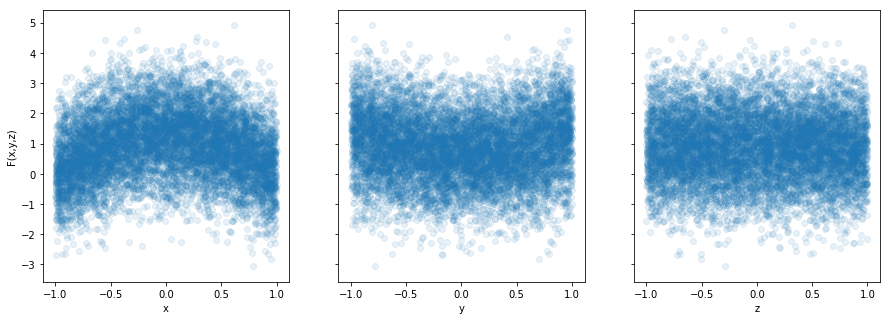

In [9]:
f,a = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
l = ["x","y","z"]
a[0].set_ylabel("F(x,y,z)")
for i,s in enumerate([x, y, z]):
    a[i].scatter(s, Fyn, alpha=0.1)
    a[i].set_xlabel(l[i])

In [10]:
data = np.zeros(n, dtype=[('hpix','i8'),('label','f8'),\
                          ('features',('f8', 3)), ('error', 'f8'),
                         ('fracgood', 'f8')])
data['hpix']    = np.zeros(Fyn.size)
data['label']   = Fyn
data['features']= np.column_stack([x, y, z])
data['error']   = error
data['fracgood'] = 1.0

In [11]:
data

array([(0,  0.90565567, [ 0.39293837,  0.32628477, -0.82704492], -0.02996776, 1.),
       (0,  2.16911021, [-0.42772133,  0.67957281,  0.16832886],  0.9747243 , 1.),
       (0,  3.08577678, [-0.54629709,  0.64730877, -0.05449618],  2.09025781, 1.),
       ...,
       (0,  2.02915176, [ 0.97028989, -0.10985332, -0.75613709],  1.96990781, 1.),
       (0, -1.05246917, [-0.55867576, -0.44585331,  0.69403342], -1.8770912 , 1.),
       (0,  2.4533142 , [ 0.22659433, -0.44012602,  0.01947624],  1.32089436, 1.)],
      dtype=[('hpix', '<i8'), ('label', '<f8'), ('features', '<f8', (3,)), ('error', '<f8'), ('fracgood', '<f8')])

In [12]:
data2fold = split2Kfolds(data, k=3)

In [13]:
print("RMSE of fold0 errors %.5f"%np.std(data2fold['train']['fold0']['error']))
print("RMSE of fold1 errors %.5f"%np.std(data2fold['train']['fold1']['error']))
print("RMSE of fold2 errors %.5f"%np.std(data2fold['train']['fold2']['error']))

RMSE of fold0 errors 0.99748
RMSE of fold1 errors 1.00549
RMSE of fold2 errors 1.00845


In [14]:
address = "./outputs/mock/"
config = {'nchain':10,
          'nepoch':100,
          'batchsize':200,
          'Units':[5,5,5],
          'learning_rate':0.01,
          'scale':1.e-6}

for rank in [0, 1, 2]:
    fold = 'fold'+str(rank)
    print(fold, ' is being processed')
    NN.run_nchainlearning(address+fold+'/',
                   data2fold['train'][fold],
                   data2fold['validation'][fold], 
                   data2fold['test'][fold],
                  **config)

fold0  is being processed
output is saved as reg-nepoch100-nchain10-batchsize200units555-Lrate0.01-l2scale1e-06 under ./outputs/mock/fold0/
fold1  is being processed
output is saved as reg-nepoch100-nchain10-batchsize200units555-Lrate0.01-l2scale1e-06 under ./outputs/mock/fold1/
fold2  is being processed
output is saved as reg-nepoch100-nchain10-batchsize200units555-Lrate0.01-l2scale1e-06 under ./outputs/mock/fold2/


In [15]:
from glob import glob

In [16]:
files = glob("./outputs/mock/fold*/*nepoch100*scale1e*.npz")

In [17]:
files

['./outputs/mock/fold0/reg-nepoch100-nchain10-batchsize200units555-Lrate0.01-l2scale1e-06.npz',
 './outputs/mock/fold1/reg-nepoch100-nchain10-batchsize200units555-Lrate0.01-l2scale1e-06.npz',
 './outputs/mock/fold2/reg-nepoch100-nchain10-batchsize200units555-Lrate0.01-l2scale1e-06.npz']

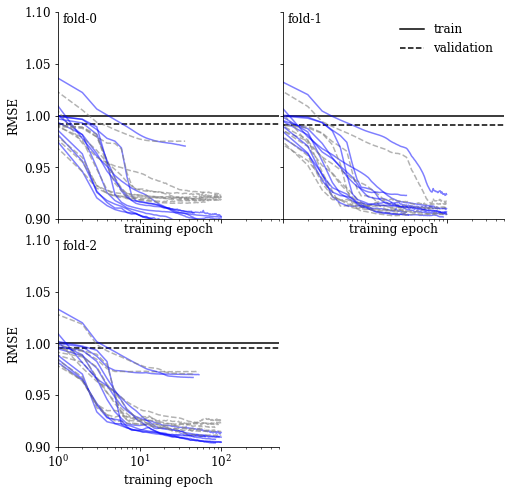

In [18]:
plt.rc('font', size=12, family='Serif')
plt.rc('axes.spines', right=False, top=False)
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.1)
ax = ax.flatten()
f.delaxes(ax[-1])
for j,file_i in enumerate(files):
    d = np.load(file_i)
    out = d['arr_0'].item()
#     print(out.keys(), out['options'])
#     break
    for i,mse in enumerate(out['epoch_MSEs']):
        if i == 0:
            ax[j].axhline(np.sqrt(out['options']['baselineMSE'][0]), ls='-', c='k', label='train')
            ax[j].axhline(np.sqrt(out['options']['baselineMSE'][1]), ls='--', c='k', label='validation')

        ax[j].plot(mse[-1][:,0], np.sqrt(mse[-1][:,1]),ls='-',c='blue', alpha=0.5)
        ax[j].plot(mse[-1][:,0], np.sqrt(mse[-1][:,2]),ls='--',c='grey', alpha=0.6)
    ax[j].set_xscale('log')
    ax[j].text(0.02, 0.95, "fold-"+str(j), transform=ax[j].transAxes, fontsize=12)
    if j ==1:ax[j].legend(frameon=False, loc='upper right')
    ax[j].set_ylim(0.9, 1.1)
#     ax[j].text(100, 1.02*rmse[2], "Baseline RMSE", color="k")
    if j in [0, 2]:ax[j].set_ylabel('RMSE')
    if j in [2, 3]:ax[j].set_xlabel('Training Epoch')
    ax[j].set_xlim(1, 500)
    ax[j].set_xlabel("training epoch")

Blue solid lines stand for training RMSEs, while grey dashed lines are testing RMSEs. Different lines stand for different chains, just as a check for convergence. Horizontal solid (dashed) black line stands for train (test) baseline RMSEs.

In [19]:
# this function loops over the outputs and combines them
_,X,Yt,Yp,_,_ = NN.read_NNfolds(files)

In [20]:
X.shape, Yt.shape, Yp.shape

((10000, 3), (10000,), (10000,))

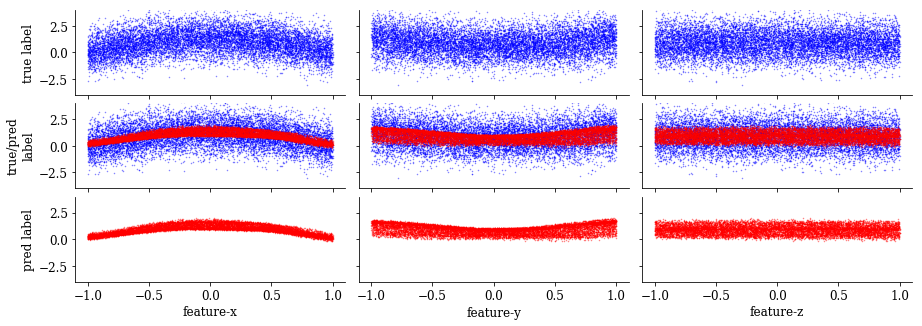

In [21]:
f,a = plt.subplots(ncols=3, nrows=3, figsize=(15,5),
                  sharey=True, sharex=True)
a = a.flatten()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

k = 0
for j in range(3):
    a[0+k].scatter(X[:,j], Yt, 1, marker='.', c='b', alpha=0.5)
    a[6+k].scatter(X[:,j], Yp, 1, marker='.', c='r', alpha=0.5)
    a[3+k].scatter(X[:,j], Yt, 1, marker='.', c='b', alpha=0.5)
    a[3+k].scatter(X[:,j], Yp, 1, marker='.', c='r', alpha=0.5)
    k += 1

for a_i in a:
    a_i.set_ylim(-4., 4.)
    
l = ['true label', 'true/pred\nlabel', 'pred label']
for j,i in enumerate([0, 3, 6]):
    a[i].set_ylabel(l[j])
l = ['x', 'y', 'z']
for j,i in enumerate([6,7,8]):
    a[i].set_xlabel("feature-"+l[j])